## Comparison of GloGEM, PyGEM, and OGGM RGI 17 Runoff Outputs 

This notebook is a copy of SAndes_GloPyOG_AggregateBasinComp. In this notebook we examine the possibilities for large differences in inter-model runoff projections.

Last Updated: 23 June 2023 | FFW

### Aggregation of GloGEM runoff:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import date
import collections
import datetime
import os

## Generic the filepath to the main data folder
fpath0 = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/Runoff-intercomparison/GloGEM-output/RGI17-SouthernAndes/files/'  

#All of the climate models used
modelnames = ['BCC-CSM2-MR','CAMS-CSM1-0','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0', 'NorESM2-MM']

SSPpaths = ['ssp126','ssp245','ssp370','ssp585']   #Specifiying the SSP
#SSPs = ['ssp119','ssp126','ssp245','ssp370','ssp585'] #Use a different path as we have all 5 ssps for volume

In [3]:
all_discharges = [[] for _ in SSPpaths]

for s, SSPpath in enumerate(SSPpaths):
    model_discharges = []
    for modelname in modelnames:
        temp_df = pd.read_csv(fpath0 + modelname + '/' + SSPpaths[s]  + '/' + 'southernandes_Discharge_r1.dat', sep='\s+', header=None, skiprows=1, index_col=0)
        model_discharges.append(temp_df)
    all_discharges[s] = model_discharges

In [4]:
all_areas = [[] for _ in SSPpaths]

for s, SSPpath in enumerate(SSPpaths):
    model_areas = []
    for modelname in modelnames:
        temp_df = pd.read_csv(fpath0 + modelname  + '/' + SSPpaths[s]  + '/' + 'southernandes_Area_r1.dat', sep='\s+', index_col="ID")
        model_areas.append(temp_df)
    all_areas[s] = model_areas

In [5]:
# Create new index using pandas date_range function
start_date = datetime.date(1980, 1, 1)
end_date = datetime.date(2100, 12, 1)
new_indices = pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m').tolist()

# Apply new index and datetime conversion
for s, SSPpath_discharges in enumerate(all_discharges):
    for m, discharge_df in enumerate(SSPpath_discharges):
        all_discharges[s][m].columns = new_indices
        all_discharges[s][m].columns = pd.to_datetime(new_indices)

In [6]:
#expanding area dataset to match year-month dimension
for s in range(len(SSPpaths)):
    for i in range(len(all_areas[s])):
        all_areas[s][i] = all_areas[s][i][all_areas[s][i].columns.repeat(12)]
        
for s, areas in enumerate(all_areas):
    for i, area in enumerate(areas):
        all_areas[s][i].columns = new_indices
        all_areas[s][i].columns = pd.to_datetime(new_indices)

In [7]:
# We will use our initial area to compute runoff so we fill entire dfs with element 0
# We only use one SSP because the initial areas are all the same -- we save time without looping through all
# We also convert km^2 to m^2

initial_areas = [pd.DataFrame(df.iloc[:, 0].values.repeat(df.shape[1]).reshape(df.shape), index=df.index, columns=df.columns).mul(1e6) for df in all_areas[0]]

In [8]:
runoff = {s: {m: None for m in modelnames} for s in SSPpaths} # create nested dictionary indexed by model name and ssp
n=0
for s in SSPpaths:
    i=0
    for m in modelnames:
        runoff[s][m] = pd.concat([initial_areas[i] * all_discharges[n][i]], axis=1)
        i+=1
    n+=1

In [9]:
import itertools
annualrunoff = {s: {m: None for m in modelnames} for s in SSPpaths}
for s, m in itertools.product(SSPpaths, modelnames):
    annualrunoff[s][m] = runoff[s][m].transpose().resample('A').sum() * 1e-9  #m^3 to km^3

In [10]:
import json
def select_glaciers_json(basin='all'):
    '''
    Select glaciers within a basin by MRBID from a json-file,
    which is stored in the data directory.

    Args:
    -----
    basin: str
        String of MRBID or 'all'.

    Returns:
    --------
    If basin is 'all' a list of all relevant glaciers is returned, for
    initiating glacier simulations. If basin is a MRBID the list of glaciers
    within that basin is returned.
    
    Copy of a function written by Erik Holmgren (2022) in holmgren_gha.utils
    '''

    # fpath = './data/rgi_ids_per_basin.json'
    fpath = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/rgi_ids_per_basin.json'  
    with open(fpath) as f:
        basin_dict = json.load(f)

    if basin.lower() != 'all':
        glacier_list = basin_dict[basin]
    else:
        glacier_list = list(itertools.chain.from_iterable(basin_dict.values()))

    return glacier_list

In [11]:
def sum_basin(basin_RGI_list, runoff_data):
    # Create new list to match our RGI formatting
    new_basin_list = [int(str(x)[-4:]) for x in basin_RGI_list]
    runoff_data = runoff_data.transpose()
    
    #TODO: create list of glaciers within a basin that are not included in GloGEM output
    # Filter new_basin_list to keep only the indexes present in the DataFrame
    new_basin_list = [x for x in new_basin_list if x in runoff_data.index]
    
    # Extract glaciers contained in the list from original df and create a new df
    new_df = runoff_data.loc[new_basin_list].copy()
    
    # Sum the values of the glaciers within the basin
    summed_basin_runoff = new_df.sum()
    #print(summed_basin_runoff)
    
    return summed_basin_runoff

In [12]:
#Generating the aggregated basin data
alpine_basins = {'YELCHO':'3429', 'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 
                'PASCUA':'3420', 'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 
                'BIOBIO':'3405', 'BAKER':'3404', 'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 
                'NEGRO':'3232', 'COLORADO':'3212', 'CHICO':'3209'} 

basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
          'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']

modelnames_glo = ['BCC-CSM2-MR','CAMS-CSM1-0','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0', 'NorESM2-MM']

scenarios = ['ssp126','ssp245','ssp370','ssp585']

basin_sums_glo = {}
for s, SSP in enumerate(scenarios):
    basin_sums_glo[SSP] = {}
    for b, basin in enumerate(basins):
        basin_sums_glo[SSP][basin] = {}
        for m, model in enumerate(modelnames_glo):
            basin_sums_glo[SSP][basin][model] = sum_basin(select_glaciers_json(alpine_basins[basin]), annualrunoff[SSP][model]) 

In [13]:
#To calculate multi GCM means and Quartiles we convert to df then calculate across first axis (GCMs)
GCM_mean_glo = {}
GCM_q1_glo = {}
GCM_q3_glo = {}
for s, SSP in enumerate(SSPpaths):
    GCM_mean_glo[SSP] = {}
    GCM_q1_glo[SSP] = {}
    GCM_q3_glo[SSP] = {}
    for b, basin in enumerate(basins):
        GCM_mean_glo[SSP][basin] = pd.DataFrame(basin_sums_glo[SSP][basin]).mean(axis=1)
        GCM_q1_glo[SSP][basin] = pd.DataFrame(basin_sums_glo[SSP][basin]).quantile(q=0.25, axis=1)
        GCM_q3_glo[SSP][basin] = pd.DataFrame(basin_sums_glo[SSP][basin]).quantile(q=0.75, axis=1)

### Aggregation of PyGEM runoff:

In [14]:
import xarray as xr

#All of the climate models used
modelnames_py = ['BCC-CSM2-MR','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0', 'NorESM2-MM']

SSPs = ['ssp126','ssp245','ssp370','ssp585'] #List of all SSPs in PyGEM

alpine_basins = {'YELCHO':'3429', 'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 
                'PASCUA':'3420', 'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 
                'BIOBIO':'3405', 'BAKER':'3404', 'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 
                'NEGRO':'3232', 'COLORADO':'3212', 'CHICO':'3209'} 

basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
          'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']

test_basin = alpine_basins['BIOBIO'] 

#Generic filepath to navigate to Drive folder 
fpathPy = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/Runoff-intercomparison/PyGEM/17'

In [15]:
basin_gls = {}
for basin, code in alpine_basins.items():
    basin_gls[basin] = select_glaciers_json(code)

In [16]:
#Importing all runoff data, taking annual sum, and converting m^3 to km^3
import glob   #use glob to group files by filename similarities (in this case, SSP)

rf_ds = {}
annual_rf_ds = {}
for s, SSP in enumerate(SSPs):
    fpath1 = '/R17_runoff_monthly_c2_ba1_1set_2000_2100-{}'.format(SSP)
    file_pattern = f'{fpathPy + fpath1}*.nc'
    file_list = glob.glob(file_pattern)
    #print(file_list)
    
    datasets = []  # Create an empty list for each SSP
    if file_list:
        for file in file_list:
            with xr.open_dataset(file) as ds:
                ds = ds.glac_runoff_monthly.load()
                datasets.append(ds)
    
        combined_ds = xr.concat(datasets, dim='glacier')  # Concatenate the datasets
        rf_ds[SSP] = combined_ds
        annual_rf_ds[SSP] = rf_ds[SSP].resample(time='A').sum() * 1e-9

In [17]:
# Sorting into basins
basin_datasets = {}
for basin, glacier_list in basin_gls.items():
    ## loop over them all, drop the irrelevant IDs, and concatenate the result
    basin_datasets[basin] = {}
    for s, SSP in enumerate(SSPs):
        ds_list = []
        try:
            ds_filtered = annual_rf_ds[SSP].where(annual_rf_ds[SSP].RGIId.isin(glacier_list), drop=True)
            #print(ds_filtered)
            ds_list.append(ds_filtered)
        except ValueError: ## happens if there are no glaciers from this batch in the selected region
            continue
        basin_datasets[basin][SSP] = xr.concat(ds_list, dim='glacier')

In [18]:
#Flipping indexing (to match other models) and summing basins
basin_sums_py = {}
for s, SSP in enumerate(SSPs):        
    basin_sums_py[SSP] = {}
    for basin, glacier_list in basin_gls.items():
        basin_sums_py[SSP][basin] = basin_datasets[basin][SSP].sum(dim='glacier')

In [19]:
#Compute multi GCM means and quartiles
GCM_mean_py = {}
GCM_q1_py = {}
GCM_q3_py = {}
for s, SSP in enumerate(SSPs):
    GCM_mean_py[SSP] = {}
    GCM_q1_py[SSP] = {}
    GCM_q3_py[SSP] = {}
    for basin in basins:
        GCM_mean_py[SSP][basin] = basin_sums_py[SSP][basin].mean(dim = 'model')
        GCM_q1_py[SSP][basin] = basin_sums_py[SSP][basin].quantile(q = 0.25, dim = 'model')
        GCM_q3_py[SSP][basin] = basin_sums_py[SSP][basin].quantile(q = 0.75, dim = 'model')

### Introducing OGGM Runoff

In [20]:
#All of the climate models used
modelnames_OG = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5','EC-Earth3', 
                'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8','INM-CM5-0', 
                 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM', 'TaiESM1']

alpine_basins = {'YELCHO':'3429', 'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 
                'PASCUA':'3420', 'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 
                'BIOBIO':'3405', 'BAKER':'3404', 'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 
                'NEGRO':'3232', 'COLORADO':'3212', 'CHICO':'3209'} 

# CMCC-CM2-SR5 & TaiESM1 only hold values for ssp585––this is model list without those GCMS
modelnames_OG_trimmed = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 
                         'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8',
                           'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']

#Generic filepath to navigate to Drive folder 
fpathOG1 = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/'
fpathOG2 = 'Lizz Research Stuff/Runoff-intercomparison/OGGM/lschuster/runs_2023.3/output/basins/'

In [21]:
#Importing all runoff data, OGGM is grouped by basin
for basin, ID in alpine_basins.items():
    fpath_basin = 'gcm_from_2000_bc_2000_2019/{}/'.format(ID)
    #print(f'{fpathOG1 + fpathOG2 + fpath_basin}*.nc')
    with xr.open_mfdataset(f'{fpathOG1 + fpathOG2 + fpath_basin}*.nc') as ds:
        ds = ds.runoff.load()
    rf_ds[basin] = ds

In [22]:
#Summing individual glacier runoff into basin totals and converting kg to km^3
basin_rf_OG = {}
for basin, ID in alpine_basins.items():
    basin_rf_OG[basin] = rf_ds[basin].sum(dim = 'rgi_id') * 1e-12

In [23]:
#creating dict of GloPy format
basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
          'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']
basin_sums_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    basin_sums_OG[which_ssp] = {}
    for b, basin in enumerate(basins):
        basin_sums_OG[which_ssp][basin] = basin_rf_OG[basin].sel(scenario = which_ssp)

In [24]:
#Removing these GCMs for ALL SSPs--doing even 585 as these two are not included...
#... in Glo or Py so not only makeds OOGM easier but maintains GCM consistency in analysis
trimmed_basin_sums_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    trimmed_basin_sums_OG[which_ssp] = {}
    for b, basin in enumerate(basins):
        trimmed_basin_sums_OG[which_ssp][basin] = xr.concat([basin_sums_OG[which_ssp][basin][0:4], basin_sums_OG[which_ssp][basin][5:-1]], dim='gcm')

In [25]:
#Compute multi GCM means and quartiles for OGGM
GCM_mean_OG = {}
GCM_q1_OG = {}
GCM_q3_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    GCM_mean_OG[which_ssp] = {}
    GCM_q1_OG[which_ssp] = {}
    GCM_q3_OG[which_ssp] = {}
    for basin in basins:
        GCM_mean_OG[which_ssp][basin] = trimmed_basin_sums_OG[which_ssp][basin].mean(dim = 'gcm')
        GCM_q1_OG[which_ssp][basin] = trimmed_basin_sums_OG[which_ssp][basin].quantile(q = 0.25, dim = 'gcm')
        GCM_q3_OG[which_ssp][basin] = trimmed_basin_sums_OG[which_ssp][basin].quantile(q = 0.75, dim = 'gcm')

In [26]:
#Plot setup
from cycler import cycler
import matplotlib.patches as mpatches

scenarios = ['ssp126','ssp245','ssp370','ssp585']

basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
          'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']

basinstext = ['Yelcho', 'Valdivia', 'Serrano','Rapel','Puelo', 'Pascua', 'Palena', 'Huasco', 'Copiapo', 
          'Cisnes', 'Biobio', 'Baker', 'Azopardo', 'Aisen', 'Santa Cruz', 'Negro', 'Colorado', 'Chico']

yrs_glo = np.arange(1980,2101)
yrs_glo_dt = pd.to_datetime([str(y)for y in yrs_glo])

colors_glo =  plt.colormaps['Greens']
line_colors_glo = colors_glo(np.linspace(0.2, 0.6, num = 12))
glo_cycler = cycler(color = line_colors_glo)

colors_py =  plt.colormaps['Purples']
line_colors_py = colors_py(np.linspace(0.2, 0.6,num = 12))
py_cycler = cycler(color = line_colors_py)

colors_OG =  plt.colormaps['Blues']
line_colors_OG = colors_OG(np.linspace(0.2, 0.6,num = 12))
OG_cycler = cycler(color = line_colors_OG)

In [27]:
# #Calculating inter-GCM variance
#COMMENTING OUT TO FOCUS ON RF DISCPRENCIES

# variance_glo = {}
# variance_py = {}
# variance_OG = {}
# for s, SSP in enumerate(SSPs):
#     variance_glo[SSP] = {}
#     variance_py[SSP] = {}
#     variance_OG[SSP] = {}
#     for b, basin in enumerate(basins):
#         variance_glo[SSP][basin] = pd.DataFrame(basin_sums_glo[SSP][basin]).var(axis=1)
#         variance_py[SSP][basin] = basin_sums_py[SSP][basin].var(dim = 'model')
#         variance_OG[SSP][basin] =  trimmed_basin_sums_OG[SSP][basin].var(dim = 'gcm')

Text(-1.3, 21.5, 'SSP 126                            SSP 245                           SSP 370                            SSP 585')

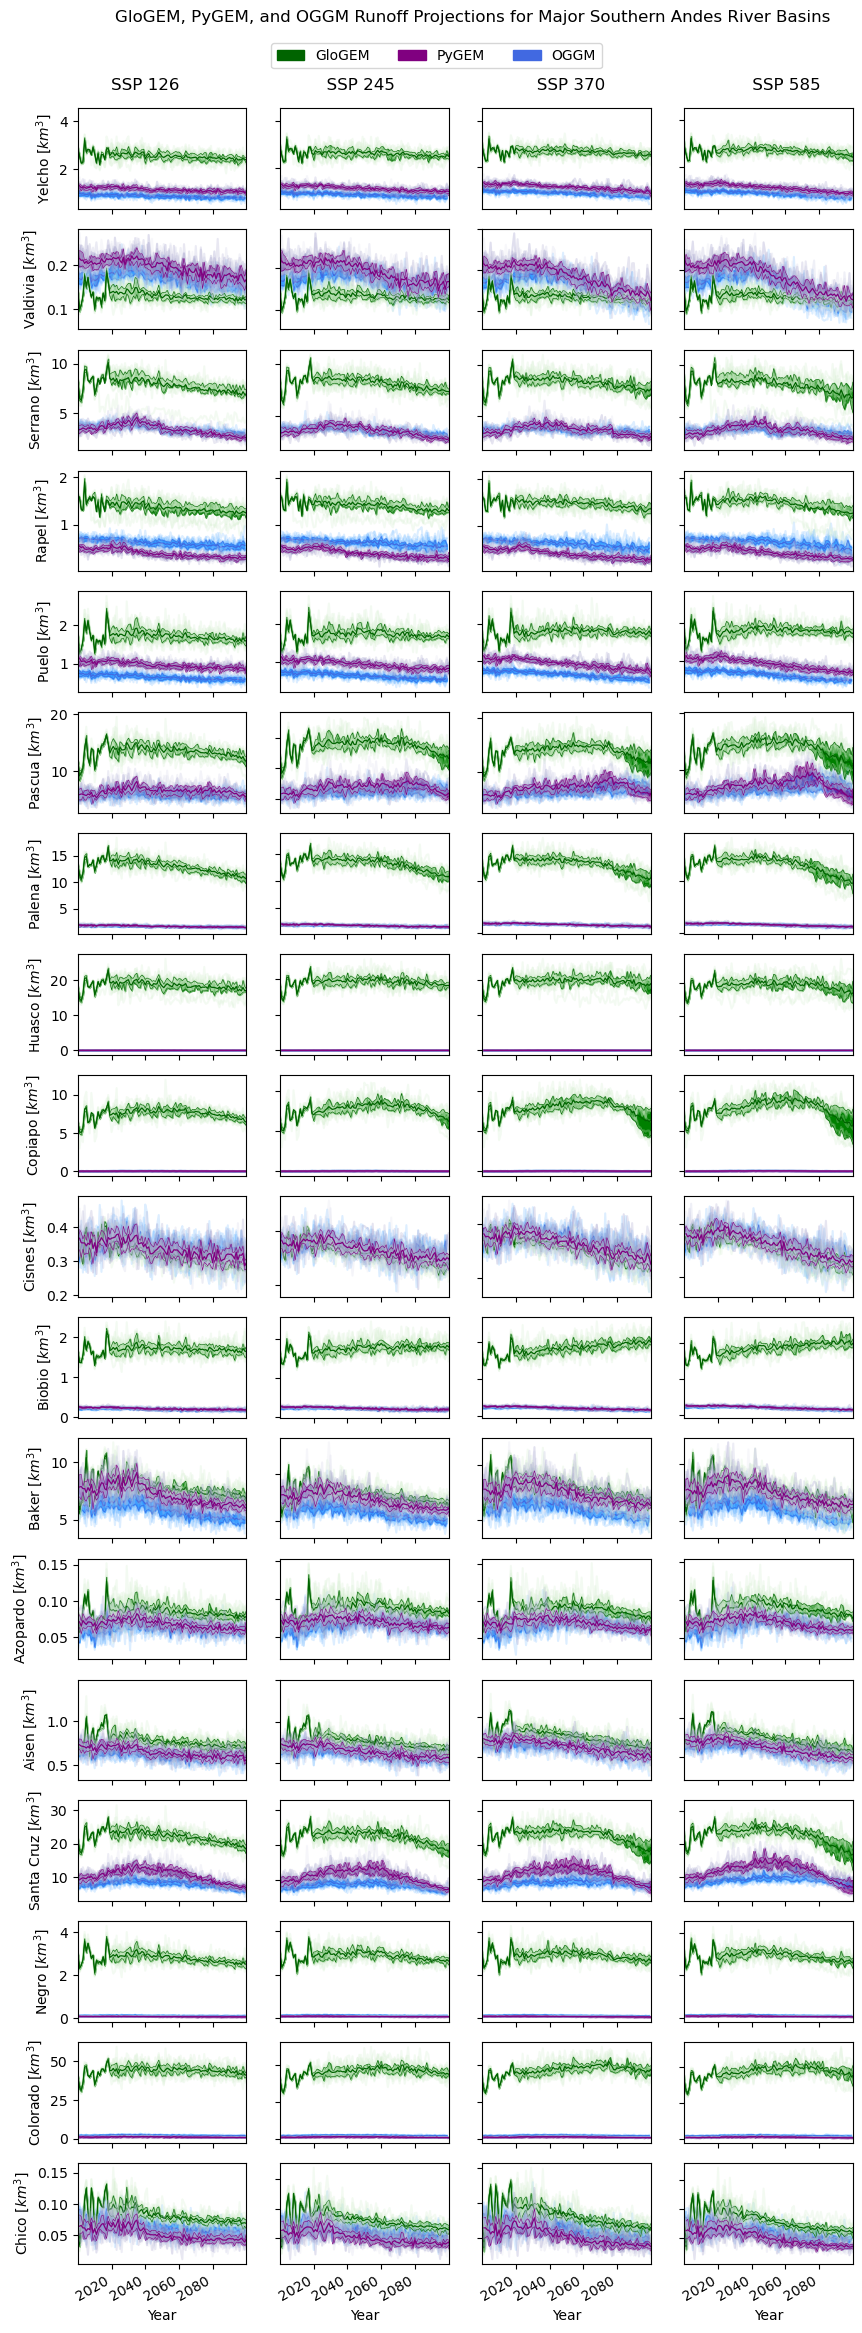

In [28]:
#Same plot as above with OGGM data added
#Also flipping axes so that l to r reads as one basin with increasing scenario severity 
#Plotting all data
fig, axs = plt.subplots(len(basins), len(SSPs), figsize=(10, 28), sharex=True)
for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    for b, basin in enumerate(basins):

        #OG won't plot with built-in ds.plot()
        #Trim last value as it goes to zero
        for m, model in enumerate(modelnames_OG_trimmed):
            axs[b,s].plot(yrs_glo_dt[20:-1], trimmed_basin_sums_OG[which_ssp][basin][:,0:-1].sel(gcm = modelnames_OG_trimmed[m]), color = 'dodgerblue', alpha = 0.15)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_mean_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'dodgerblue', alpha = 0.5)

        #Trim first value as it is incomplete hydrological year
        for m in modelnames_glo:
            axs[b, s].plot(yrs_glo_dt, basin_sums_glo[which_ssp][basin][m], color=axs[b, s].set_prop_cycle(glo_cycler), alpha = 0.25)
        axs[b,s].plot(yrs_glo_dt, GCM_mean_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt, GCM_q1_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt, GCM_q3_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt, GCM_q1_glo[which_ssp][basin], GCM_q3_glo[which_ssp][basin], color = 'green')
        axs[b, s].set(xlim=(pd.to_datetime('2000-01-01'), pd.to_datetime('2100-01-01')))

        basin_sums_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color=axs[b, s].set_prop_cycle(py_cycler), alpha = 0.25, add_legend=False)
        GCM_mean_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color = 'purple', linewidth = 0.9, add_legend=False)
        GCM_q1_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color = 'purple', linewidth = 0.4, add_legend=False)
        GCM_q3_py[which_ssp][basin].plot(hue='model', ax=axs[b, s], color = 'purple', linewidth = 0.4, add_legend=False)
        axs[b,s].fill_between(yrs_glo_dt[20::], GCM_q1_py[which_ssp][basin], GCM_q3_py[which_ssp][basin], color = 'Purple')
        axs[b,s].set(title = '')

        #Make mean more clear for RHONE, which overlaps significantly w Glo
        #axs[b,s].plot(yrs_glo_dt[20:-1], GCM_mean_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.9)

        #Setting x and y labels and making y limits uniform within basins
        if b == (len(basins)-1):
            for sub_s in range(4):  # Use a different variable name for the inner loop
                axs[b, sub_s].set_xlabel('Year')
                axs[b, sub_s].set_xticks([pd.to_datetime('2020'),pd.to_datetime('2040'), pd.to_datetime('2060'), pd.to_datetime('2080')], [2020, 2040, 2060, 2080])
        else:
            axs[b, s].set_xlabel(None) 
        
        if s == 0:                                                                    #Setting basin labels
            for sub_b in range(len(basins)):
                axs[sub_b,s].set_ylabel(basinstext[sub_b]+ r' $[km^3]$')
        if s != 0:
            axs[b, s].set_ylabel(None)
            axs[b, s].set_yticklabels('')

green_patch = mpatches.Patch(color='darkgreen', label='GloGEM')
purple_patch = mpatches.Patch(color='purple', label='PyGEM') 
blue_patch = mpatches.Patch(color='royalblue', label='OGGM')
axs[0,0].legend(handles=[green_patch, purple_patch, blue_patch], bbox_to_anchor=(3.15, 1.71), ncol=3)

plt.suptitle('GloGEM, PyGEM, and OGGM Runoff Projections for Major Southern Andes River Basins', x=0.52, y=0.915)
plt.title('SSP 126                            SSP 245                           SSP 370                            SSP 585', x=-1.3, y=21.5) 

In [29]:
#COMMENTING OUT TO FOCUS ON RF DISCPRENCIES

# scenarios = ['ssp126','ssp245','ssp370','ssp585']

# basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
#           'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']

# basinstext = ['Yelcho', 'Valdivia', 'Serrano','Rapel','Puelo', 'Pascua', 'Palena', 'Huasco', 'Copiapo', 
#           'Cisnes', 'Biobio', 'Baker', 'Azopardo', 'Aisen', 'Santa Cruz', 'Negro', 'Colorado', 'Chico']

# fig, axs = plt.subplots(len(basins), len(scenarios), figsize=(10, 28), sharex=True)
# for s, SSP in enumerate(scenarios):
#     for b, basin in enumerate(basins):
#         axs[b,s].plot(yrs_glo_dt[20::], variance_glo[SSP][basin][20::].rolling(window=15).mean(), color = 'forestgreen', label = 'GloGEM')
#         axs[b,s].plot(yrs_glo_dt[20::], variance_py[SSP][basin].rolling(time=15).mean(), color = 'purple', label = 'PyGEM')
#         axs[b,s].plot(yrs_glo_dt[20::], variance_OG[SSP][basin].rolling(time=15).mean(), color = 'royalblue', label = 'OGGM')
            
#         if b == (len(basins)-1):
#             for sub_s in range(4):  # Use a different variable name for the inner loop
#                 axs[b, sub_s].set_xlabel('Year')
#                 axs[b, sub_s].set_xticks([pd.to_datetime('2025'),pd.to_datetime('2050'), pd.to_datetime('2075'), pd.to_datetime('2100')], [2025, 2050, 2075, 2100])
#         if s == 0:                                                                    #Setting basin labels
#             for sub_b in range(len(basins)):
#                 axs[sub_b,s].set_ylabel(basinstext[sub_b])
#         if s != 0:
#             axs[b, s].set_ylabel(None)
#             axs[b, s].set_yticklabels('')
        
# axs[0,0].legend(bbox_to_anchor=(3.15, 1.72), ncol=3)
# plt.suptitle('GloGEM, PyGEM, and OGGM inter-GCM Variance in Runoff Projections for Major Central European River Basins', x=0.52, y=0.915)
# plt.title('SSP 126                                 SSP 245                                SSP 370                                 SSP 585', x=-1.3, y=21.5) 

In [30]:
#Comparing the output of Erik Holmgren's function (which is inputted directly to create GloGEM summed basin rf) 
#to glaciers in the unprocessed PyGEM basin dataset
select_glaciers_json(alpine_basins['BIOBIO']) == basin_datasets['BIOBIO']['ssp126'].RGIId.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [31]:

basin_datasets['BIOBIO']['ssp126'].RGIId.values == rf_ds['BIOBIO'].rgi_id.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [32]:
#Confirming that Nan values are not the source of the error
#All nans returned here are the final value of the OGGM dataarray-a constant accross all regions
sum(np.isnan(rf_ds['BIOBIO'].sel(scenario='ssp126', gcm = modelnames_OG_trimmed)))

<xarray.DataArray 'runoff' (time: 101, rgi_id: 138)>
array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [13, 13, 13, ..., 13, 13, 13]])
Coordinates:
  * time             (time) float64 2e+03 2.001e+03 ... 2.099e+03 2.1e+03
  * rgi_id           (rgi_id) object 'RGI60-17.12649' ... 'RGI60-17.12997'
    scenario         <U6 'ssp126'
    hydro_year       (time) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
    hydro_month      (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
    calendar_year    (time) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
    calendar_month   (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    bias_correction  <U12 'bc_2000_2019'
    gcm              <U10 'NorESM2-MM'